In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp
from matplotlib.colors import LogNorm
from scipy import stats

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
sweep_list = ['sweep-000m010-010m005', 'sweep-010m010-020m005', 'sweep-020m010-030m005', 'sweep-030m010-040m005', 'sweep-040m010-050m005', 'sweep-050m010-060m005', 'sweep-060m010-070m005', 'sweep-070m010-080m005', 'sweep-120m010-130m005', 'sweep-130m010-140m005', 'sweep-140m010-150m005', 'sweep-150m010-160m005', 'sweep-160m010-170m005', 'sweep-170m010-180m005', 'sweep-180m010-190m005', 'sweep-190m010-200m005', 'sweep-200m010-210m005', 'sweep-210m010-220m005', 'sweep-220m010-230m005', 'sweep-230m010-240m005', 'sweep-300m010-310m005', 'sweep-310m010-320m005', 'sweep-320m010-330m005', 'sweep-330m010-340m005', 'sweep-340m010-350m005', 'sweep-350m010-360m005', 'sweep-000m005-010p000', 'sweep-010m005-020p000', 'sweep-020m005-030p000', 'sweep-030m005-040p000', 'sweep-040m005-050p000', 'sweep-050m005-060p000', 'sweep-060m005-070p000', 'sweep-070m005-080p000', 'sweep-110m005-120p000', 'sweep-120m005-130p000', 'sweep-130m005-140p000', 'sweep-140m005-150p000', 'sweep-150m005-160p000', 'sweep-160m005-170p000', 'sweep-170m005-180p000', 'sweep-180m005-190p000', 'sweep-190m005-200p000', 'sweep-200m005-210p000', 'sweep-210m005-220p000', 'sweep-220m005-230p000', 'sweep-230m005-240p000', 'sweep-240m005-250p000', 'sweep-250m005-260p000', 'sweep-300m005-310p000', 'sweep-310m005-320p000', 'sweep-320m005-330p000', 'sweep-330m005-340p000', 'sweep-340m005-350p000', 'sweep-350m005-360p000', 'sweep-000p000-010p005', 'sweep-010p000-020p005', 'sweep-020p000-030p005', 'sweep-030p000-040p005', 'sweep-040p000-050p005', 'sweep-050p000-060p005', 'sweep-060p000-070p005', 'sweep-070p000-080p005', 'sweep-110p000-120p005', 'sweep-120p000-130p005', 'sweep-130p000-140p005', 'sweep-140p000-150p005', 'sweep-150p000-160p005', 'sweep-160p000-170p005', 'sweep-170p000-180p005', 'sweep-180p000-190p005', 'sweep-190p000-200p005', 'sweep-200p000-210p005', 'sweep-210p000-220p005', 'sweep-220p000-230p005', 'sweep-230p000-240p005', 'sweep-240p000-250p005', 'sweep-250p000-260p005', 'sweep-300p000-310p005', 'sweep-310p000-320p005', 'sweep-320p000-330p005', 'sweep-330p000-340p005', 'sweep-340p000-350p005', 'sweep-350p000-360p005', 'sweep-000p005-010p010', 'sweep-010p005-020p010', 'sweep-020p005-030p010', 'sweep-030p005-040p010', 'sweep-040p005-050p010', 'sweep-110p005-120p010', 'sweep-120p005-130p010', 'sweep-130p005-140p010', 'sweep-140p005-150p010', 'sweep-150p005-160p010', 'sweep-160p005-170p010', 'sweep-170p005-180p010', 'sweep-180p005-190p010', 'sweep-190p005-200p010', 'sweep-200p005-210p010', 'sweep-210p005-220p010', 'sweep-220p005-230p010', 'sweep-230p005-240p010', 'sweep-240p005-250p010', 'sweep-250p005-260p010', 'sweep-260p005-270p010', 'sweep-300p005-310p010', 'sweep-310p005-320p010', 'sweep-320p005-330p010', 'sweep-330p005-340p010', 'sweep-340p005-350p010', 'sweep-350p005-360p010']
print(len(sweep_list))

111


In [4]:
# sweep_list = ['sweep-140p015-150p020', 'sweep-150p015-160p020',
#               'sweep-160p015-170p020', 'sweep-170p015-180p020', 
#               'sweep-180p015-190p020', 'sweep-190p015-200p020',
#               'sweep-140p010-150p015', 'sweep-150p010-160p015',
#               'sweep-160p010-170p015', 'sweep-170p010-180p015', 
#               'sweep-180p010-190p015', 'sweep-190p010-200p015',
#               'sweep-140p005-150p010', 'sweep-150p005-160p010',
#               'sweep-160p005-170p010', 'sweep-170p005-180p010', 
#               'sweep-180p005-190p010', 'sweep-190p005-200p010']

gaia_stack = []
cat_stack = []
for sweep_fn in sweep_list:
    
    gaia = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/dr9_south_cross_match/'+sweep_fn+'-gaia.fits'))
    cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/dr9_south_cross_match/'+sweep_fn+'-ls.fits'))
    # print(len(gaia))

    mask = gaia['PHOT_G_MEAN_MAG']<17.65
    gaia = gaia[mask]
    cat = cat[mask]
    # print(len(gaia))

    # maskbits = [0, 2, 3, 4, 5, 6, 7, 10, 12, 13]
    maskbits = [0, 1, 10, 12, 13]
    mask_clean = np.ones(len(cat), dtype=bool)
    for bit in maskbits:
        mask_clean &= (cat['MASKBITS'] & 2**bit)==0
    # print(np.sum(~mask_clean)/len(mask_clean))
    gaia = gaia[mask_clean]
    cat = cat[mask_clean]
    # print(len(gaia))

    mask = (cat['FLUX_G']>0) & (cat['FLUX_R']>0) & (cat['FLUX_Z']>0)
    mask &= (cat['FLUX_IVAR_G']>0) & (cat['FLUX_IVAR_R']>0) & (cat['FLUX_IVAR_Z']>0)
    mask &= (cat['FRACFLUX_G']<0.1) & (cat['FRACFLUX_R']<0.1) & (cat['FRACFLUX_Z']<0.1)
    gaia = gaia[mask]
    cat = cat[mask]
    # print(len(gaia))
    
    gaia_stack.append(gaia)
    cat_stack.append(cat)
    # print()

gaia = vstack(gaia_stack)
cat = vstack(cat_stack)
print(len(gaia))

4553051


In [5]:
print(len(cat))

4553051


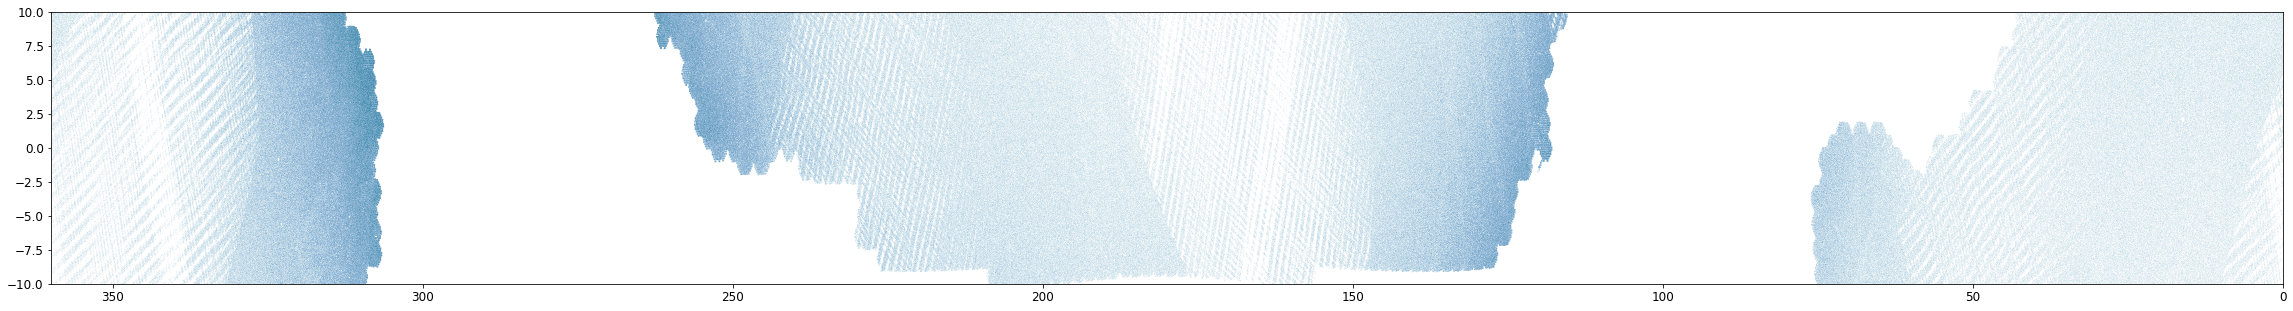

In [6]:
plt.figure(figsize=(40, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.1)
plt.axis([360, 0, -10, 10])
plt.show()

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    gaia['gmag'] = 22.5 - 2.5*np.log10(gaia['flux_g'])
    gaia['rmag'] = 22.5 - 2.5*np.log10(gaia['flux_r'])
    gaia['zmag'] = 22.5 - 2.5*np.log10(gaia['flux_z'])

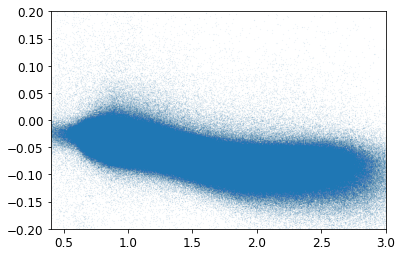

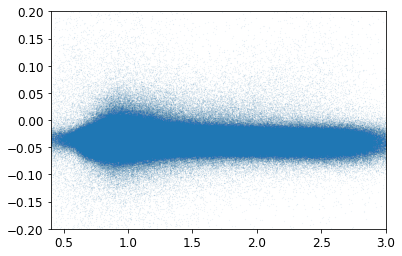

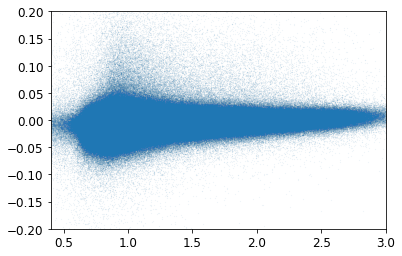

In [8]:
mask = (cat['ANYMASK_G']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['gmag']-gaia['gmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

mask = (cat['ANYMASK_R']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['rmag']-gaia['rmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

mask = (cat['ANYMASK_Z']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['zmag']-gaia['zmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

In [9]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

def poly_val1d(x, m):
    '''
    Evaluate the 1D polynomial from x values and polynomial parameters
    
    See also rlm_fit1d.py
    
    INPUT:
    1D array of x values; 
    1D array of polynomial parameters (for example generated by 
    rlm_fit1d.py).
    
    OUTPUT:
    1D array of the evaluated values of the polynomial.
    '''
    
    order = len(m)-1
    z = np.zeros(x.shape)
    for i in range(order+1):
        z += m[i] * x**i
    return z

In [ ]:
coeffs = {}

for band in ['g', 'r', 'z']:
    mask = (cat['ANYMASK_'+band.upper()]==0)
    # mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>-0.6
    # mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<4.5
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.5
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<3.0
    x = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    y = (cat[band+'mag']-gaia[band+'mag'])[mask]
    poly_order = 5
    coeffs[band] = rlm_fit1d(x, y, t=0.02, order=poly_order)
    print(band)
    print(coeffs[band])

np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

coeffs

In [10]:
coeffs = {'g': np.array([0.0290853720, -0.2512460050, 0.4404641812, -0.3773360105,
        0.1398971000, -0.0185162342]),
 'r': np.array([-0.0611700882, 0.0716741628, -0.0648957317, 0.0248411929,
        -0.0039454092, 0.0001510852]),
 'z': np.array([-0.0606614222, 0.1323440401, -0.1156708755, 0.0470817681,
        -0.0084565308, 0.0005163927])}

__Transformations are only valid for 0.5<BP-RP<3.0__

In [11]:
for band in ['g', 'r', 'z']:
    x = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])
    gaia[band+'mag_std'] = gaia[band+'mag'] + poly_val1d(x, coeffs[band])

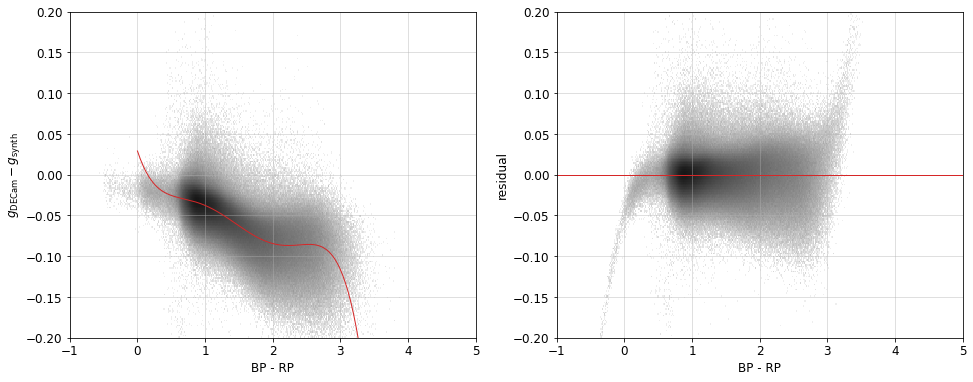

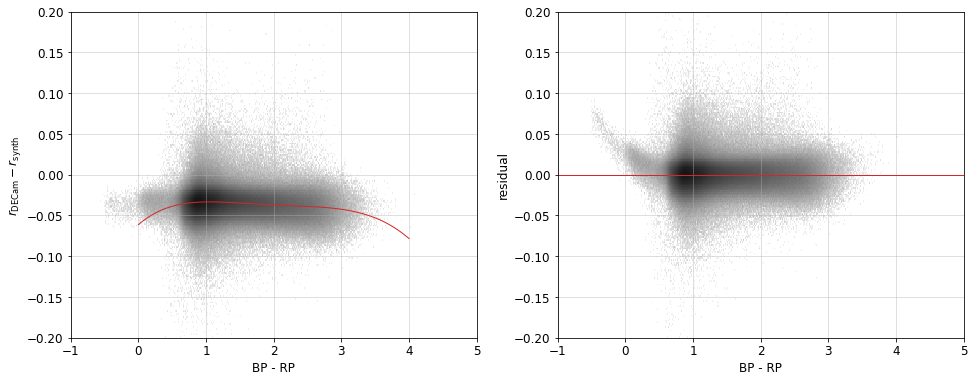

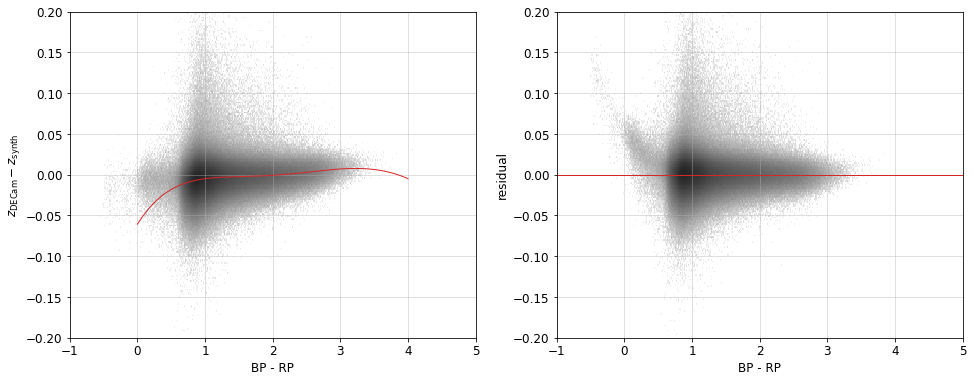

In [28]:
for band in ['g', 'r', 'z']:
    mask = (cat['ANYMASK_'+band.upper()]==0)
    x = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    y = (cat[band+'mag']-gaia[band+'mag'])[mask]

    y_predict = poly_val1d(x, coeffs[band])
    x_plot = np.linspace(0, 4, 200)
    y_plot = poly_val1d(x_plot, coeffs[band])

    xbins, ybins = np.linspace(-1, 5, 400), np.linspace(-0.2, 0.2, 200)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    ax.hist2d(x, y, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.plot(x_plot, y_plot, '-', lw=1., color='C3')
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{synth}$'
    ax.set_ylabel(ylabel)
    ax.axis([-1, 5, -0.2, 0.2])
    ax.grid(alpha=0.5)
    ax = axes[1]
    ax.hist2d(x, y-y_predict, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.axhline(0, lw=1, color='C3', ls='-')
    ax.set_xlabel('BP - RP')
    ax.set_ylabel('residual')
    ax.axis([-1, 5, -0.2, 0.2])
    ax.grid(alpha=0.5)
    plt.show()

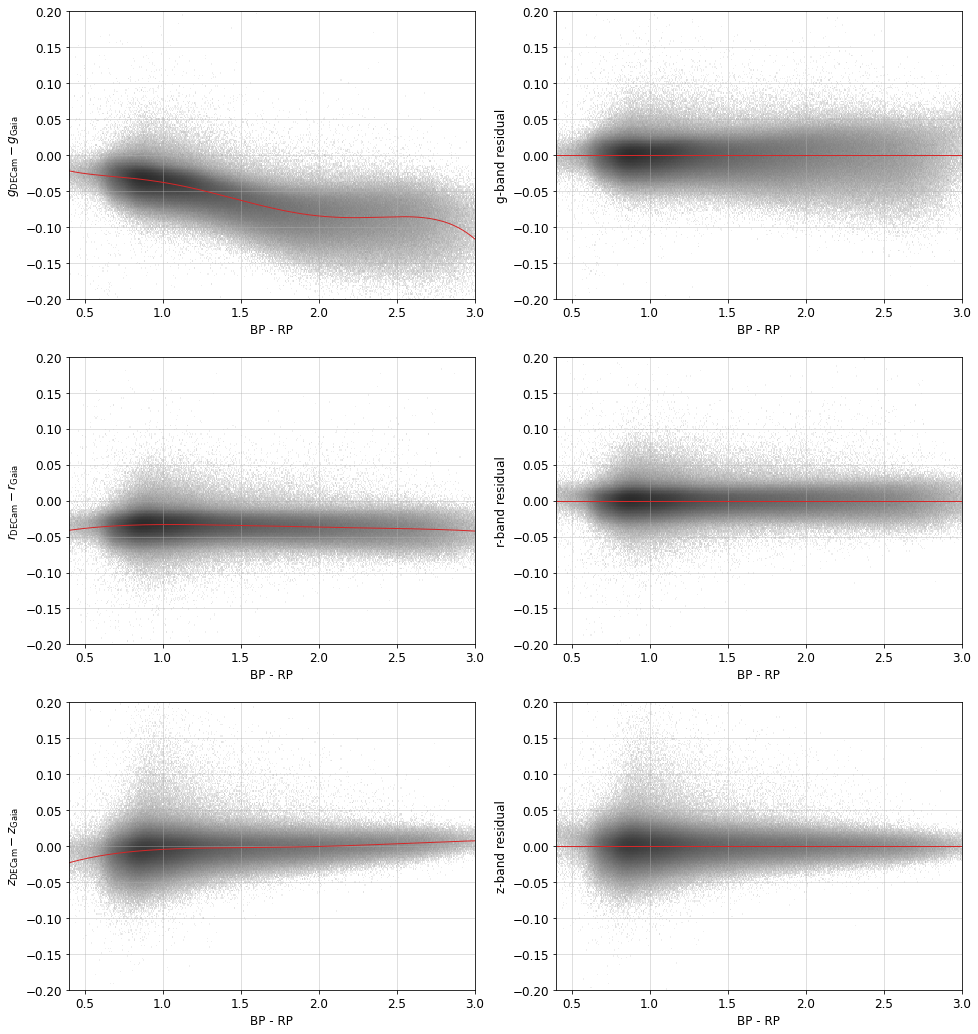

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    x = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    y = (cat[band+'mag']-gaia[band+'mag'])[mask]
    mask = np.isfinite(y)
    x, y = x[mask], y[mask]

    y_predict = poly_val1d(x, coeffs[band])
    x_plot = np.linspace(0, 4, 200)
    y_plot = poly_val1d(x_plot, coeffs[band])

    xbins, ybins = np.linspace(0.4, 3., 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(0.4, 3., 100)
    ax = axes[index, 0]
    ax.hist2d(x, y, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.plot(x_plot, y_plot, '-', lw=1., color='C3')
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_median, bin_edges, _ = stats.binned_statistic(x, y, statistic='median', bins=xbins1)
    # bin_16, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    # ax.plot(bin_centers, bin_median, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_16, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia}$'
    ax.set_ylabel(ylabel)
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
    ax = axes[index, 1]
    ax.hist2d(x, y-y_predict, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.axhline(0, lw=1, color='C3', ls='-')
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_median, bin_edges, _ = stats.binned_statistic(x, y-y_predict, statistic='median', bins=xbins1)
    # bin_16, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    # ax.plot(bin_centers, bin_median, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_16, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ax.set_ylabel(band+'-band residual')
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
plt.show()

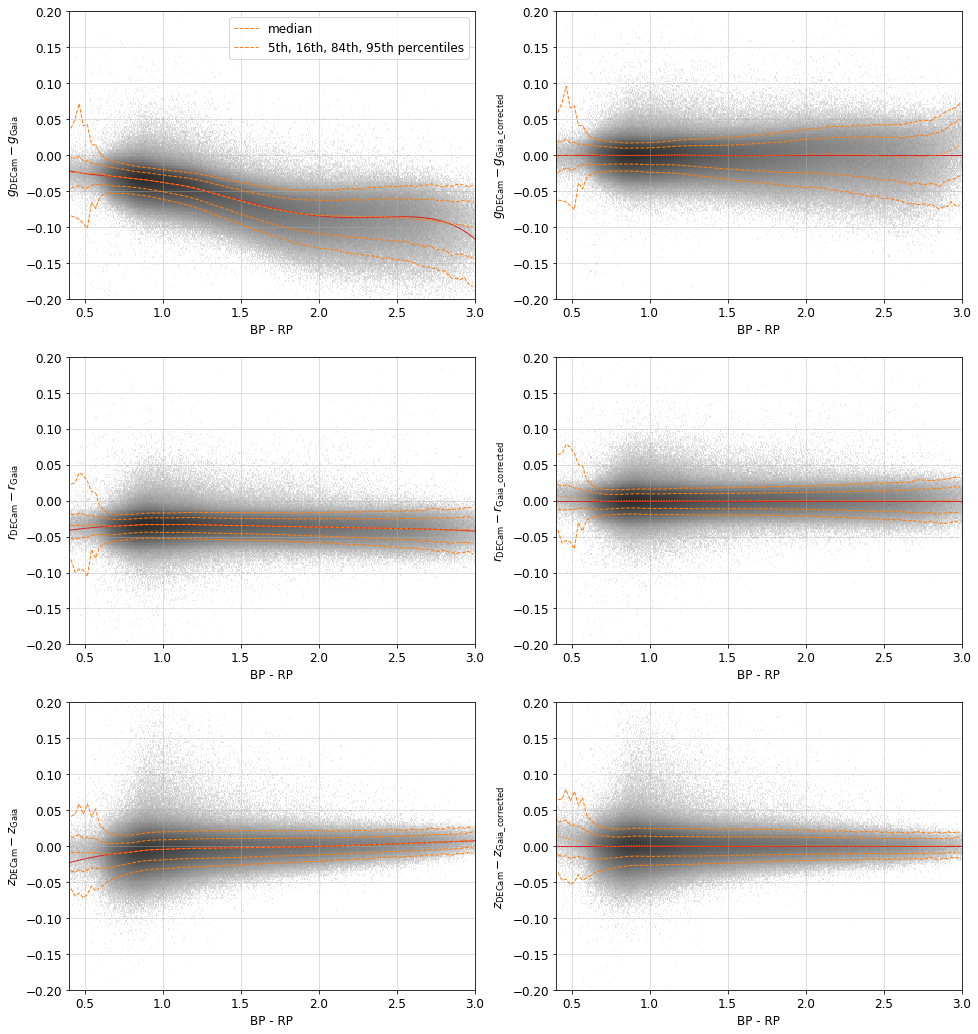

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    x = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    y = (cat[band+'mag']-gaia[band+'mag'])[mask]
    mask = np.isfinite(y)
    x, y = x[mask], y[mask]

    y_predict = poly_val1d(x, coeffs[band])
    x_plot = np.linspace(0, 4, 200)
    y_plot = poly_val1d(x_plot, coeffs[band])

    xbins, ybins = np.linspace(0.4, 3., 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(0.4, 3., 100)
    ax = axes[index, 0]
    ax.hist2d(x, y, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.plot(x_plot, y_plot, '-', lw=1., color='C3')
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_median, bin_edges, _ = stats.binned_statistic(x, y, statistic='median', bins=xbins1)
    bin_16, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    bin_84, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    bin_5, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    bin_95, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    ax.plot(bin_centers, bin_median, 'C1--', lw=1., label='median')
    ax.plot(bin_centers, bin_16, 'C1--', lw=1., label='5th, 16th, 84th, 95th percentiles')
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia}$'
    ax.set_ylabel(ylabel)
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
    if index==0:
        ax.legend(loc='upper right')
    ax = axes[index, 1]
    ax.hist2d(x, y-y_predict, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.axhline(0, lw=1, color='C3', ls='-')
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_median, bin_edges, _ = stats.binned_statistic(x, y-y_predict, statistic='median', bins=xbins1)
    bin_16, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    bin_84, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    bin_5, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    bin_95, _, _ = stats.binned_statistic(x, y-y_predict, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    ax.plot(bin_centers, bin_median, 'C1:', lw=1.)
    ax.plot(bin_centers, bin_16, 'C1--', lw=1.)
    ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia\_corrected}$'
    ax.set_ylabel(ylabel)
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


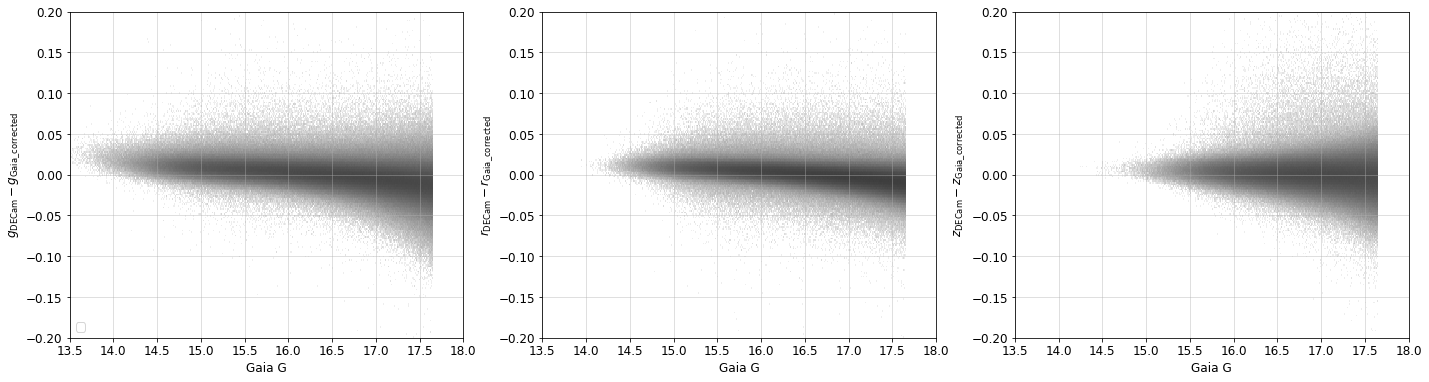

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) > 0.6
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) < 2.5
    x = gaia['PHOT_G_MEAN_MAG'][mask].copy()
    y = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    mask = np.isfinite(y)
    x, y = x[mask], y[mask]
    xbins, ybins = np.linspace(13.5, 18, 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(13.5, 18, 100)
    ax = axes[index]
    ax.hist2d(x, y, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    # bin_median, bin_edges, _ = stats.binned_statistic(x, y, statistic='median', bins=xbins1)
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_16, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    # bin_count, _ = np.histogram(x, bins=xbins1)
    # mask = bin_count>200
    # ax.plot(bin_centers[mask], bin_median[mask], 'C1:', lw=1., label='median')
    # ax.plot(bin_centers[mask], bin_16[mask], 'C1--', lw=1., label='5th, 16th, 84th, 95th percentiles')
    # ax.plot(bin_centers[mask], bin_84[mask], 'C1--', lw=1.)
    # ax.plot(bin_centers[mask], bin_5[mask], 'C1--', lw=1.)
    # ax.plot(bin_centers[mask], bin_95[mask], 'C1--', lw=1.)
    ax.set_xlabel('Gaia G')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia\_corrected}$'
    ax.set_ylabel(ylabel)
    ax.axis([13.5, 18, -0.2, 0.2])
    ax.grid(alpha=0.5)
    if index==0:
        ax.legend(loc='lower left')
plt.show()

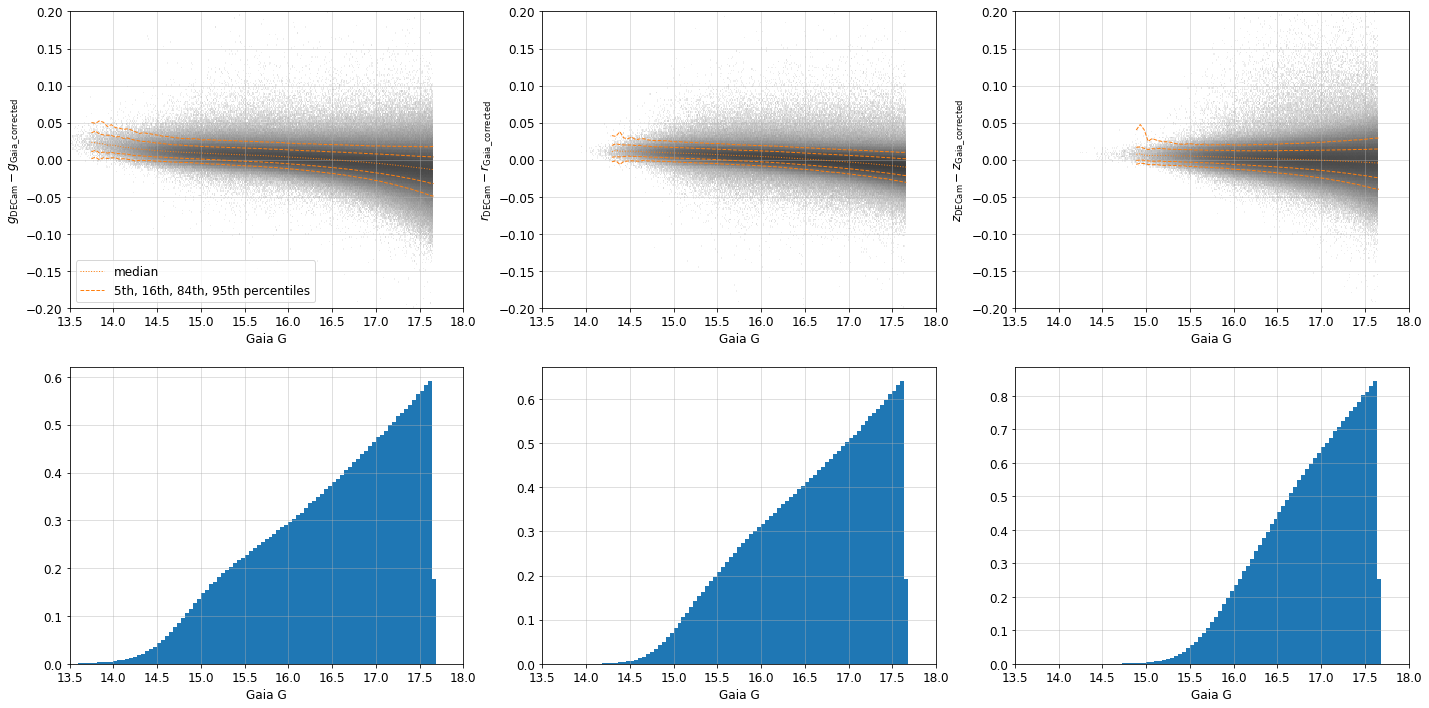

In [99]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) > 0.6
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) < 2.5
    x = gaia['PHOT_G_MEAN_MAG'][mask].copy()
    y = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    mask = np.isfinite(y)
    x, y = x[mask], y[mask]
    xbins, ybins = np.linspace(13.5, 18, 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(13.5, 18, 100)
    ax = axes[0, index]
    ax.hist2d(x, y, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    bin_median, bin_edges, _ = stats.binned_statistic(x, y, statistic='median', bins=xbins1)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_16, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 15.9), bins=xbins1)
    bin_84, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 84.1), bins=xbins1)
    bin_5, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 5), bins=xbins1)
    bin_95, _, _ = stats.binned_statistic(x, y, statistic=lambda y: np.percentile(y, 95), bins=xbins1)
    bin_count, _ = np.histogram(x, bins=xbins1)
    mask = bin_count>200
    ax.plot(bin_centers[mask], bin_median[mask], 'C1:', lw=1., label='median')
    ax.plot(bin_centers[mask], bin_16[mask], 'C1--', lw=1., label='5th, 16th, 84th, 95th percentiles')
    ax.plot(bin_centers[mask], bin_84[mask], 'C1--', lw=1.)
    ax.plot(bin_centers[mask], bin_5[mask], 'C1--', lw=1.)
    ax.plot(bin_centers[mask], bin_95[mask], 'C1--', lw=1.)
    ax.set_xlabel('Gaia G')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia\_corrected}$'
    ax.set_ylabel(ylabel)
    ax.axis([13.5, 18, -0.2, 0.2])
    ax.grid(alpha=0.5)
    if index==0:
        ax.legend(loc='lower left')
for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    x = gaia['PHOT_G_MEAN_MAG'][mask].copy()
    y = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    mask = np.isfinite(y)
    x, y = x[mask], y[mask]
    ax = axes[1, index]
    xbins1 = np.linspace(13.5, 18, 100)
    ax.hist(x, bins=xbins1, density=True)
    ax.set_xlabel('Gaia G')
    ax.set_xlim(13.5, 18)
    ax.grid(alpha=0.5)
plt.show()

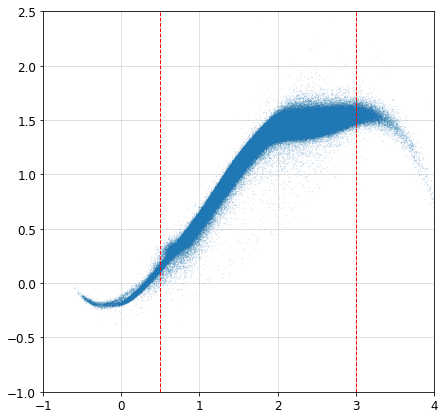

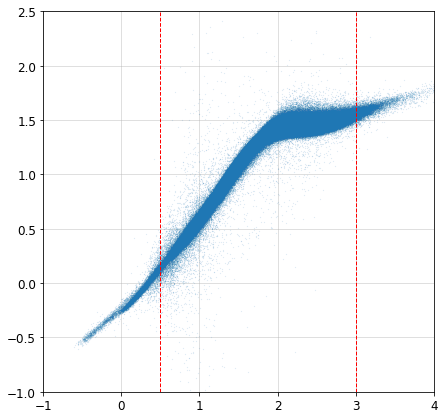

In [29]:
x = gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']
y = gaia['gmag_std'] - gaia['rmag_std']
mask = (x<100)
plt.figure(figsize=(7, 7))
plt.plot(x[mask], y[mask], '.', ms=0.1)
plt.axis([-1, 4, -1, 2.5])
plt.axvline(0.5, lw=1, ls='--', color='r')
plt.axvline(3., lw=1, ls='--', color='r')
plt.grid(alpha=0.5)
plt.show()

x = gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']
y = cat['gmag'] - cat['rmag']
mask = (x<100)
mask &= (cat['ANYMASK_G']==0) & (cat['ANYMASK_R']==0)
plt.figure(figsize=(7, 7))
plt.plot(x[mask], y[mask], '.', ms=0.1)
plt.axis([-1, 4, -1, 2.5])
plt.axvline(0.5, lw=1, ls='--', color='r')
plt.axvline(3., lw=1, ls='--', color='r')
plt.grid(alpha=0.5)
plt.show()

In [1]:
# band = 'g'
# mask = (cat['ANYMASK_'+band.upper()]==0)
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.6
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<2.5
# idx = np.where(mask)[0]
# print(len(idx))
# # idx = np.sort(np.random.choice(idx, size=len(idx)//10))

# plt.figure(figsize=(40, 5))
# plt.scatter(cat['RA'][idx], cat['DEC'][idx], c=(cat[band+'mag'] - gaia[band+'mag_std'])[idx], s=0.5, vmin=-0.01, vmax=0.01)
# plt.axis([360, 0, -10, 10])
# plt.show()


# band = 'r'
# mask = (cat['ANYMASK_'+band.upper()]==0)
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.6
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<2.5
# idx = np.where(mask)[0]
# print(len(idx))
# # idx = np.sort(np.random.choice(idx, size=len(idx)//10))

# plt.figure(figsize=(40, 5))
# plt.scatter(cat['RA'][idx], cat['DEC'][idx], c=(cat[band+'mag'] - gaia[band+'mag_std'])[idx], s=0.5, vmin=-0.01, vmax=0.01)
# plt.axis([360, 0, -10, 10])
# plt.show()


# band = 'z'
# mask = (cat['ANYMASK_'+band.upper()]==0)
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.6
# mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<2.5
# idx = np.where(mask)[0]
# print(len(idx))
# # idx = np.sort(np.random.choice(idx, size=len(idx)//10))

# plt.figure(figsize=(40, 5))
# plt.scatter(cat['RA'][idx], cat['DEC'][idx], c=(cat[band+'mag'] - gaia[band+'mag_std'])[idx], s=0.5, vmin=-0.01, vmax=0.01)
# plt.axis([360, 0, -10, 10])
# plt.show()